Library Import

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load image function to Load the images



In [3]:
# cat_img = []
# dog_img = []
# panda_img = []

def load_images(folder,label):
  images = []
  labels = []
  for filename in os.listdir(folder):
    path = os.path.join(folder,filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
      img = cv2.resize(img,(32,32))
      img = img.flatten()
      images.append(img)
      labels.append(label)
  return images,labels

Load and Covert to numpy array

In [4]:
base_path = '/content/drive/MyDrive/CVPR/Mid/animal_dataset'
cat_img,cat_labels = load_images(os.path.join(base_path,'cat'),0)
dog_img,dog_labels = load_images(os.path.join(base_path,'dog'),1)
panda_img,panda_labels = load_images(os.path.join(base_path,'panda'),2)

X = np.array(cat_img+dog_img+panda_img)
y = np.array(cat_labels+dog_labels+panda_labels)


Check the Shape and Size

In [5]:
print("Number of cat images:", len(cat_img))
print("Number of dog images:", len(dog_img))
print("Number of panda images:", len(panda_img))

Number of cat images: 100
Number of dog images: 100
Number of panda images: 100


In [6]:
print(X.shape) # 32 * 32 = 1024
print(y.shape)

(300, 1024)
(300,)


Visualize if images loaded or not

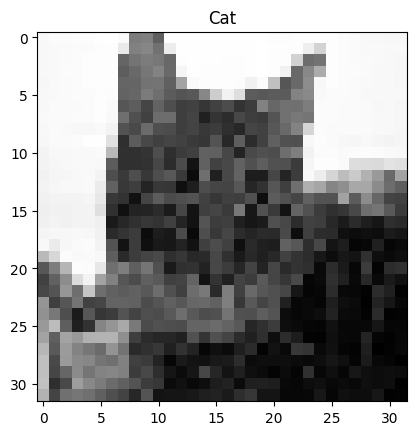

In [7]:
import matplotlib.pyplot as plt

plt.imshow(cat_img[2].reshape(32, 32), cmap='gray')
plt.title("Cat")
plt.show()

Suffling the images

In [8]:
indices = np.arange(len(X))
# print(indices)
np.random.shuffle(indices)
# print(indices)
# print(X)
X = X[indices]
# print(X)
y = y[indices]



Euclidean & Manhattan distence measurement function to implement KNN

In [9]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def predict(X_train, y_train, x_test, k, distance_metric="euclidean"):
    distances = []
    for i in range(len(X_train)):
      if distance_metric == "euclidean":
        distance = euclidean_distance(X_train[i], x_test)
      elif distance_metric == "manhattan":
        distance = manhattan_distance(X_train[i], x_test)
      distances.append((distance, y_train[i]))
    # sort the list of tuples by distance
    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    return max(set(k_labels), key=k_labels.count)

5 Fold Cross validation and KNN implementation

In [10]:
import matplotlib.pyplot as plt
import random

def create_folds(X, y, num_folds=5):
    data = list(zip(X, y))
    random.shuffle(data)
    fold_size = len(data) // num_folds
    folds = []
    for i in range(num_folds):
        start = i * fold_size
        end = (i+1)*fold_size if i < num_folds - 1 else len(data)
        fold = data[start:end]
        X_fold, y_fold = zip(*fold)
        folds.append((np.array(X_fold), np.array(y_fold)))
    return folds

k_values = list(range(1, 21))  # k=1 to 20
folds = create_folds(X, y, num_folds=5)

# ---------------- Euclidean ----------------

euclidean_fold_accuracies = [[] for _ in range(5)]
euclidean_average_accuracies = []

for k in k_values:
    fold_acc = []
    for i in range(5):
        X_valid, y_valid = folds[i]
        X_train = np.concatenate([folds[j][0] for j in range(5) if j != i])
        y_train = np.concatenate([folds[j][1] for j in range(5) if j != i])

        correct = 0
        for idx in range(len(X_valid)):
            pred = predict(X_train, y_train, X_valid[idx], k, distance_metric="euclidean")
            if pred == y_valid[idx]:
                correct += 1
        acc = correct / len(X_valid)
        euclidean_fold_accuracies[i].append(acc)
        fold_acc.append(acc)

    avg_acc = np.mean(fold_acc)
    euclidean_average_accuracies.append(avg_acc)

for fold_num in range(5):
    print(f"\nFold {fold_num + 1} (Euclidean):")
    for idx, k in enumerate(k_values):
        acc = euclidean_fold_accuracies[fold_num][idx] * 100
        print(f"  Accuracy for k={k}: {acc:.2f}%")
    print(f"   Average Accuracy: {euclidean_average_accuracies[idx]*100:.2f}%")



# ---------------- Manhattan ----------------

manhattan_fold_accuracies = [[] for _ in range(5)]
manhattan_average_accuracies = []

for k in k_values:
    fold_acc = []
    for i in range(5):
        X_valid, y_valid = folds[i]
        X_train = np.concatenate([folds[j][0] for j in range(5) if j != i])
        y_train = np.concatenate([folds[j][1] for j in range(5) if j != i])

        correct = 0
        for idx in range(len(X_valid)):
            pred = predict(X_train, y_train, X_valid[idx], k, distance_metric="manhattan")
            if pred == y_valid[idx]:
                correct += 1
        acc = correct / len(X_valid)
        manhattan_fold_accuracies[i].append(acc)
        fold_acc.append(acc)

    avg_acc = np.mean(fold_acc)
    manhattan_average_accuracies.append(avg_acc)

for fold_num in range(5):
    print(f"\nFold {fold_num + 1} (Manhattan):")
    for idx, k in enumerate(k_values):
        acc = manhattan_fold_accuracies[fold_num][idx] * 100
        print(f"  Accuracy for k={k}: {acc:.2f}%")
    print(f"   Average Accuracy: {manhattan_average_accuracies[idx]*100:.2f}%")


Fold 1 (Euclidean):
  Accuracy for k=1: 21.67%
  Accuracy for k=2: 21.67%
  Accuracy for k=3: 25.00%
  Accuracy for k=4: 23.33%
  Accuracy for k=5: 20.00%
  Accuracy for k=6: 23.33%
  Accuracy for k=7: 21.67%
  Accuracy for k=8: 23.33%
  Accuracy for k=9: 25.00%
  Accuracy for k=10: 28.33%
  Accuracy for k=11: 28.33%
  Accuracy for k=12: 26.67%
  Accuracy for k=13: 31.67%
  Accuracy for k=14: 26.67%
  Accuracy for k=15: 31.67%
  Accuracy for k=16: 31.67%
  Accuracy for k=17: 33.33%
  Accuracy for k=18: 28.33%
  Accuracy for k=19: 33.33%
  Accuracy for k=20: 31.67%
   Average Accuracy: 43.00%

Fold 2 (Euclidean):
  Accuracy for k=1: 35.00%
  Accuracy for k=2: 38.33%
  Accuracy for k=3: 45.00%
  Accuracy for k=4: 41.67%
  Accuracy for k=5: 46.67%
  Accuracy for k=6: 36.67%
  Accuracy for k=7: 46.67%
  Accuracy for k=8: 45.00%
  Accuracy for k=9: 41.67%
  Accuracy for k=10: 43.33%
  Accuracy for k=11: 46.67%
  Accuracy for k=12: 41.67%
  Accuracy for k=13: 40.00%
  Accuracy for k=14: 46.

 KNN cross‑validation accuracy curve using Euclidean distance

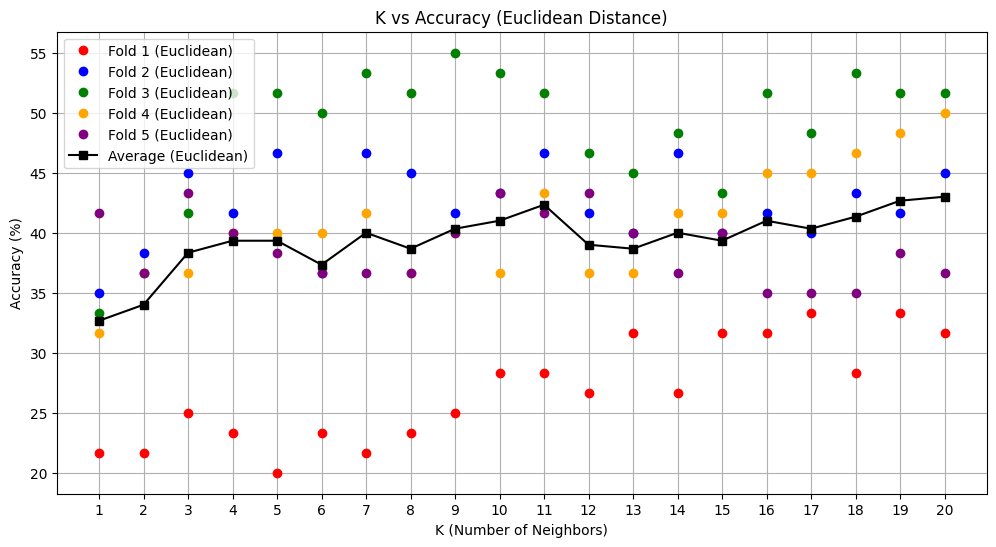

In [11]:
colors = ['red','blue','green','orange','purple']
plt.figure(figsize = (12,6))

# Plot individual fold points (Euclidean)
for i in range(5):
    plt.plot(k_values, [a*100 for a in euclidean_fold_accuracies[i]],
             linestyle='', marker='o', label=f'Fold {i+1} (Euclidean)', color=colors[i])

# Plot average line (Euclidean)
plt.plot(k_values, [a*100 for a in euclidean_average_accuracies],
         linestyle='-', marker='s', color='black', label='Average (Euclidean)')

plt.title("K vs Accuracy (Euclidean Distance)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.xticks(k_values)
plt.show()

 KNN cross‑validation accuracy curve using Manhattan distance

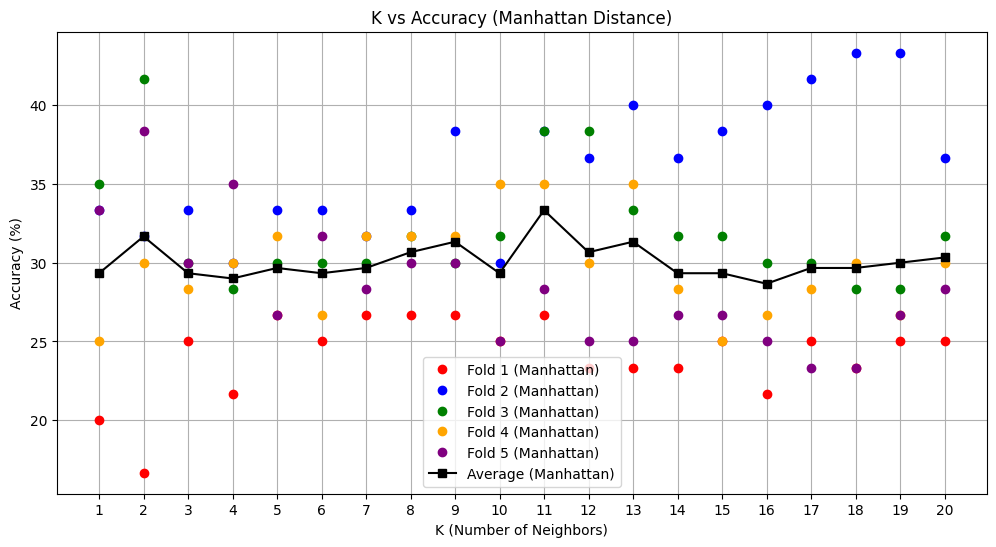

In [12]:
colors = ['red','blue','green','orange','purple']
plt.figure(figsize = (12,6))

# Plot individual fold points (Manhattan)
for i in range(5):
    plt.plot(k_values, [a*100 for a in manhattan_fold_accuracies[i]],
             linestyle='', marker='o', label=f'Fold {i+1} (Manhattan)', color=colors[i])

# Plot average line (Manhattan)
plt.plot(k_values, [a*100 for a in manhattan_average_accuracies],
         linestyle='-', marker='s', color='black', label='Average (Manhattan)')

plt.title("K vs Accuracy (Manhattan Distance)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.xticks(k_values)
plt.show()

comparison of KNN classification accuracy across different values of k using Euclidean vs Manhattan distance metrics.


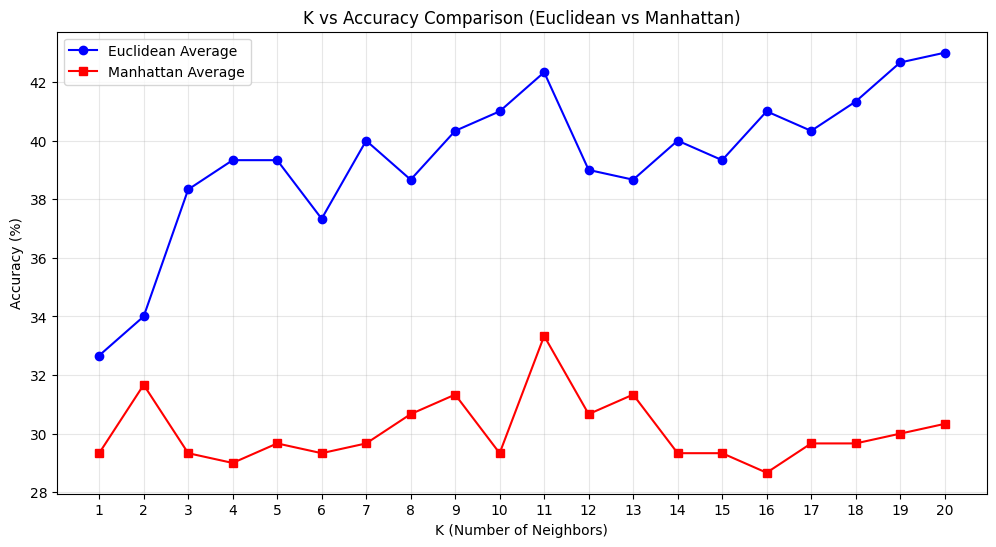

Best K for Euclidean: 20 with accuracy 43.00%
Best K for Manhattan: 11 with accuracy 33.33%


In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot Euclidean average line
plt.plot(k_values, [a*100 for a in euclidean_average_accuracies],
         linestyle='-', marker='o', color='blue', label='Euclidean Average')

# Plot Manhattan average line
plt.plot(k_values, [a*100 for a in manhattan_average_accuracies],
         linestyle='-', marker='s', color='red', label='Manhattan Average')

plt.title("K vs Accuracy Comparison (Euclidean vs Manhattan)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Accuracy (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(k_values)
plt.show()

# Print best K for each
best_k_euclidean = k_values[np.argmax(euclidean_average_accuracies)]
best_k_manhattan = k_values[np.argmax(manhattan_average_accuracies)]

print(f"Best K for Euclidean: {best_k_euclidean} with accuracy {max(euclidean_average_accuracies)*100:.2f}%")
print(f"Best K for Manhattan: {best_k_manhattan} with accuracy {max(manhattan_average_accuracies)*100:.2f}%")

# Top 5 Prediction

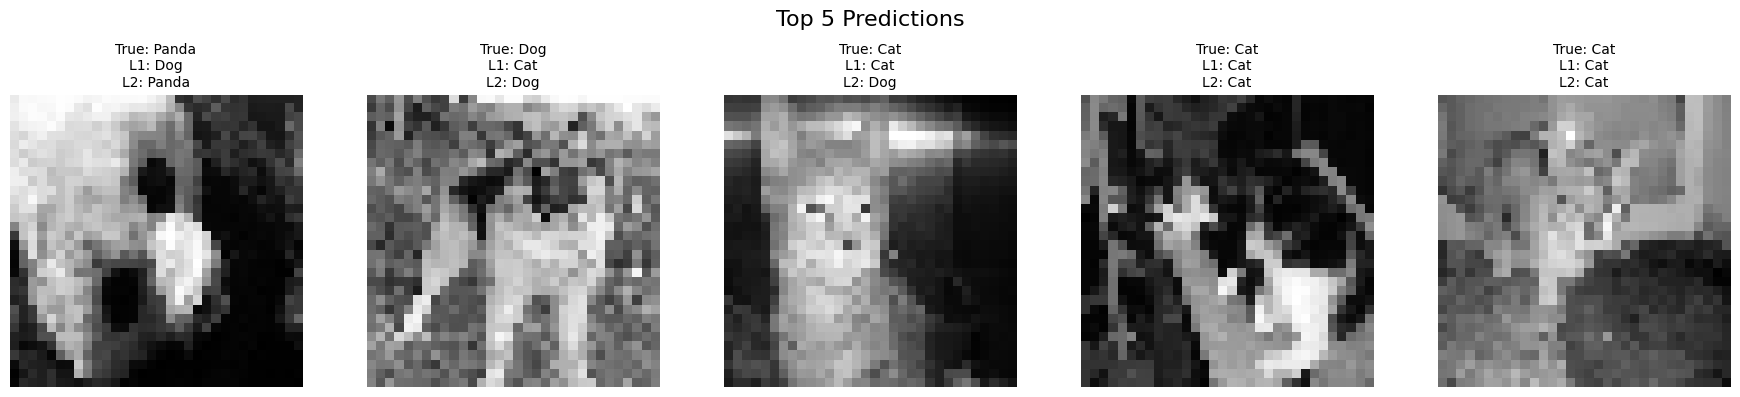

In [14]:
import random

# Define class names
classes = ["Cat", "Dog", "Panda"]

sample_ids = random.sample(range(len(X)), 5)

plt.figure(figsize=(18,4))

for i, idx in enumerate(sample_ids):
    img = X[idx]
    true_label = y[idx]

    pred_L1 = predict(X, y, img, k=3, distance_metric="manhattan")
    pred_L2 = predict(X, y, img, k=3, distance_metric="euclidean")

    plt.subplot(1,5,i+1)
    plt.imshow(img.reshape(32,32), cmap="gray")
    plt.axis("off")
    plt.title(f"True: {classes[true_label]}\nL1: {classes[pred_L1]}\nL2: {classes[pred_L2]}",
              fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.suptitle("Top 5 Predictions", fontsize=16)
plt.show()

# Discussion
  1. Using 5-fold cross-validation, Euclidean (L2) distance performed better than Manhattan (L1) for this dataset, achieving the highest accuracy of 43% with K = 20.
  2. The dataset consists of 3 classes (cat, dog, panda) preprocessed into 32×32 grayscale images. While converting to grayscale reduces computational complexity, it discards color information that is often discriminative for these animals, leading to significant feature overlap.
  3. Euclidean (L2) distance appeared better suited for this specific feature space compared to Manhattan (L1), likely because the squared differences in L2 provide a stronger signal for separating the pixel intensity vectors of these classes.

## Limitation
- The overall accuracy is relatively low (<50%), highlighting that raw pixel    intensity is a poor feature for classification. The model is also constrained by the low image resolution.

 ## POTENTIAL IMPROVEMENTS:
 Retaining RGB color channels, increasing image resolution, applying data augmentation, or employing deep learning models like CNNs would likely yield significant performance gains.